f(x[0]) = 7.25
g0(x[0]) = 4.0 >= 0
g1(x[0]) = 4.0 >= 0
g2(x[0]) = 0.0 >= 0
g3(x[0]) = 2.0 >= 0
g4(x[0]) = 0.0 >= 0
h0(x[0]) = 0.0 = 0
------Begin testing------
The equality constraint norm evaluated at x[6] is less than the global tolerance!
------End testing------
Time cost: 0.0410001277924[s]
The optimal point is (1.40000363687, 1.70000273251)
The minimum function value is 0.799998537507


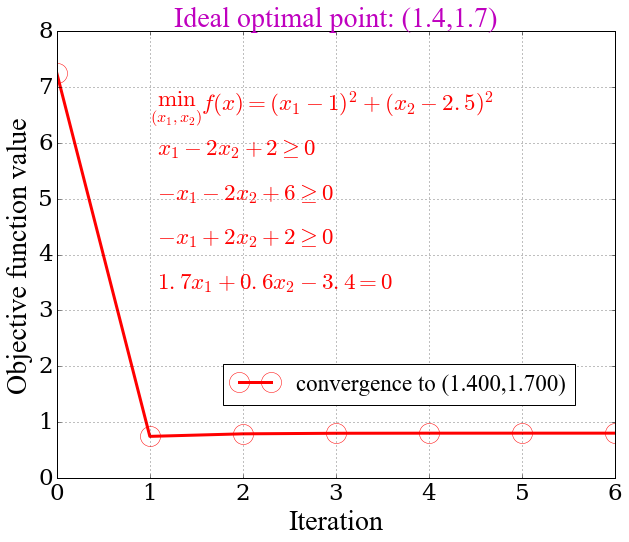

In [3]:
# -*- coding: utf-8 -*-
"""
Copyright (C) Thu Jul 13 11:01:25 2017  Jianshan Zhou
Contact: zhoujianshan@buaa.edu.cn	jianshanzhou@foxmail.com
Website: <https://github.com/JianshanZhou>
 
This module implements the optimization algorithm based on the augmented Lagrangian
multiplier method, in which some functions are coded by referring to 
the counterparts in the Scipy.optimize module.
"""
%matplotlib inline
from __future__ import division, print_function, absolute_import


import numpy as np
from scipy.optimize import fmin_bfgs

# some global constants
_epsilon = np.sqrt(np.finfo(float).eps) # the float number accuracy
# standard status messages of optimizers
_status_message = {'success': 'Optimization terminated successfully.',
                   'maxfev': 'Maximum number of function evaluations has '
                              'been exceeded.',
                   'maxiter': 'Maximum number of iterations has been '
                              'exceeded.',
                   'pr_loss': 'Desired error not necessarily achieved due '
                              'to precision loss.'}

# miscellaneous functions
class OptimizeResult(dict):
    """ Represents the optimization result.

    Attributes
    ----------
    x : ndarray
        The solution of the optimization.
    success : bool
        Whether or not the optimizer exited successfully.
    status : int
        Termination status of the optimizer. Its value depends on the
        underlying solver. Refer to `message` for details.
    message : str
        Description of the cause of the termination.
    fun, jac, hess: ndarray
        Values of objective function, its Jacobian and its Hessian (if
        available). The Hessians may be approximations, see the documentation
        of the function in question.
    hess_inv : object
        Inverse of the objective function's Hessian; may be an approximation.
        Not available for all solvers. The type of this attribute may be
        either np.ndarray or scipy.sparse.linalg.LinearOperator.
    nfev, njev, nhev : int
        Number of evaluations of the objective functions and of its
        Jacobian and Hessian.
    nit : int
        Number of iterations performed by the optimizer.
    maxcv : float
        The maximum constraint violation.

    Notes
    -----
    There may be additional attributes not listed above depending of the
    specific solver. Since this class is essentially a subclass of dict
    with attribute accessors, one can see which attributes are available
    using the `keys()` method.
    """
    def __getattr__(self, name):
        try:
            return self[name]
        except KeyError:
            raise AttributeError(name)

    __setattr__ = dict.__setitem__
    __delattr__ = dict.__delitem__

    def __repr__(self):
        if self.keys():
            m = max(map(len, list(self.keys()))) + 1
            return '\n'.join([k.rjust(m) + ': ' + repr(v)
                              for k, v in sorted(self.items())])
        else:
            return self.__class__.__name__ + "()"

    def __dir__(self):
        return list(self.keys())


def vecnorm(x, order = 2):
    """
    Calculate the norm of a vector `x` given the norm order.
    """
    if type(x) == np.ndarray:
        if order == np.Inf:
            return np.amax(np.abs(x))
        elif order == -np.Inf:
            return np.amin(np.abs(x))
        else:
            return np.sum(np.abs(x)**order, axis = 0)**(1.0/order)
    else:
        print("x is not a numpy ndarray!")
        exit(-1)


def is_array_scalar(x):
    """
    Check whether `x` is a scalar or an array scalar.
    """
    return np.size(x) == 1


def wrap_function(function, args):
    ncalls = [0]
    if function is None:
        return ncalls, None

    def function_wrapper(*wrapper_args):
        ncalls[0] += 1 # record the number of times that the function is called.
        return function(*(wrapper_args + args))

    return ncalls, function_wrapper
    

# the main functions
def ALMfunc(x, objFun, conFuns, w, v, sigma):
    """
    The augmented Lagrangian function.
    
    Parameters
    ----------
    objFun : callable function objFun(x)
        The objective function returns a scalar value.
    conFuns : callable function conFuns(x)
        The constraint function returns two arrays of the constraint values.
    w : ndarray
        The multipliers that correspond to the inequality constraints.
    v : ndarray
        The multipliers that correspond to the equality constraints.
    sigma : float
        The penalty factor.
        
    Returns
    -------
    augLagFun : scalar, a float
        The value of the augmented Lagrangian function.
    """
    ineqConFuns, eqConFuns = conFuns(x)
    if (len(ineqConFuns) != len(w)) or (len(eqConFuns) != len(v)):
        print("The multiplier number is not equal to that of the corresponding constraints!")
        exit(-1)
    sumValue1 = np.sum([(np.max([0,wi-sigma*ineqi]))**2 - wi**2 for wi, ineqi in zip(w, ineqConFuns)])
    sumValue2 = np.sum([0.5*sigma*((eqj)**2)-vj*eqj for vj, eqj in zip(v, eqConFuns)])
    return objFun(x) + sumValue1/(2.*sigma) + sumValue2


class _UnconstrainedOptimizationError(RuntimeError):
    pass


def fmin_ALM(objFun, x0, conFuns, eqConNum, ineqConNum, \
funArgs = (), conArgs = (), multiplierRange = (0.1, 1.0),\
gtol = 1e-5, sigma = 3.0, beta = 0.9, alpha = 1.3, \
norm = 2, epsilon = _epsilon, maxiter = None, full_output = 0, \
disp = 1, retall = 0, callback = None):
    """
    The optimization algorithm application interface function.
    
    Returns
    -------
    xopt : ndarray
        Parameters which minimize f, i.e. f(xopt) == fopt.
    fopt : float
        Minimum value.
    func_calls : int
        Number of function_calls made.
    conFunc_calls : int
        Number of conFunc_calls made.
    warnflag : integer
        0 : Success in the overall optimization.
        1 : Maximum number of iterations exceeded.
        2 : Failure in unconstrained optimization and/or function calls not changing.
    success flag : bool
        True : successfully solve the optimization problem.
        False : otherwise
    message : string
        A description of the final optimization achievement.
    allvecs  :  list
        `OptimizeResult` at each iteration.  Only returned if retall is True.
    """
    res = _fmin_ALM(objFun, x0, conFuns, eqConNum, ineqConNum, \
    funArgs, conArgs, multiplierRange,\
    gtol, sigma, beta, alpha, \
    norm, epsilon, maxiter, full_output, \
    disp, retall, callback)
    # fun=fval, nfev=func_calls[0], nconev=conFunc_calls[0],\
    # status=warnflag, success=(warnflag == 0), message=msg,\
    # x=xk, nit=k
    if full_output:
        retlist = (res['x'], res['fun'],\
                   res['nfev'], res['nconev'], res['status'], res['message'],\
                   res['nit'])
        if retall:
            retlist += (res['allvecs'], )
        return retlist
    else:
        if retall:
            return res['x'], res['allvecs']
        else:
            return res['x']


def _fmin_ALM(objFun, x0, conFuns, eqConNum, ineqConNum, \
funArgs = (), conArgs = (), multiplierRange = (0.1, 1.0),\
gtol = 1e-5, sigma = 3.0, beta = 0.9, alpha = 1.3, \
norm = 2, epsilon = _epsilon, maxiter = None, full_output = 0, \
disp = 1, retall = 0, callback = None):
    """
    The main entrance function of the optimization algorithm based on the
    augmented Lagrangian method.
    
    Parameters
    ----------
    objFun : callable objFun(x,*funArgs)
        Objective function to be minimized.
    x0 : ndarray
        Initial guess.
    conFuns : callable constraintFuns(x, *conArgs)
        Constraint functions in which the equality and the inequality 
        constraints are defined, returning two lists of the constraints.
    eqConNum : int
        The number of the equality constraints.
    ineqConNum : int
        The number of the inequality constraints.
    funArgs : tuple, optional
        Extra arguments passed to objFun.
    conArgs : tuple, optional
        Extra arguments passed to conFuns.
    multiplierRange : tuple, optional
        The range of the initial multipliers.
    gtol : float, optional
        Equality constraint norm must be less than gtol before successful termination.
    sigma : float, optional
        Penalty factor.
    beta : float, optional
        Threshold to indicate the relative convergence speed.
    alpha : float, optional
        Coefficient rate to increase the penalty factor when it is necessary.
    norm : float, optional
        Order of norm (Inf is max, -Inf is min)
    epsilon : int or ndarray, optional
        If fprime is approximated, use this value for the step size.
    callback : callable, optional
        An optional user-supplied function to call after each
        iteration.  Called as callback(xk), where xk is the
        current parameter vector.
    maxiter : int, optional
        Maximum number of iterations to perform.
    full_output : bool, optional
        If True,return fopt, func_calls, and warnflag
        in addition to xopt.
    disp : bool, optional
        Print convergence message if True.
    retall : bool, optional
        Return a list of results at each iteration if True.

    Notes
    -----
    In each iteration of the optimization, the optimization problem is 
    transformed into an unconstrained optimization formulation, such that the
    augmented Lagrangian objective function can be minimized by using 
    the quasi-Newton method of Broyden, Fletcher, Goldfarb, and Shanno (BFGS).
    """    
    x0 = np.asarray(x0).flatten()
    if x0.ndim == 0:
        x0.shape = (1,)
    if maxiter is None:
        maxiter = len(x0)*200
    opts = {'gtol':gtol, 
            'norm':norm,
            'epsilon':epsilon, 
            'maxiter':maxiter, 
            'full_output':1, 
            'disp':0,
            'retall':1, 
            'callback':None}
            
    func_calls, f = wrap_function(objFun, funArgs) # f is callable, i.e., f(x)
    conFunc_calls, conF = wrap_function(conFuns, conArgs) # conf in each list returned by conF(x) is callable
    allvecs = []
    
    gnorm = 1
    fval = f(x0)
    k = 0
    if retall:
        allvecs.append((x0, fval))
    
    # randomly initialize the multiplers corresponding to each constraint
    # which is within [0.1,1.0]
    if ineqConNum == 0:
        wk = np.array([])
    else:
        wk = multiplierRange[0] + (multiplierRange[1] \
        - multiplierRange[0])*np.random.rand(ineqConNum)
    if eqConNum == 0:
        vk = np.array([])
    else:
        vk = multiplierRange[0] + (multiplierRange[1] \
        - multiplierRange[0])*np.random.rand(eqConNum)
        
    xk_1 = x0
    warnflag = 0
    if callback is not None:
        callback(xk_1)
    while (gnorm > gtol) and (k < maxiter):
        # step 1:
        # construct the augmented Lagrangian function
        ALfun = lambda x : ALMfunc(x, f, conF, wk, vk, sigma)
        
        # step 2:
        # Solve the unconstrained problem for x
        try:
            res = fmin_bfgs(ALfun, xk_1, fprime=None, args=(), **opts)
            if disp:
                print("The status of the %i-th unconstrained optimization: %s"%(k, res[6]))
        except _UnconstrainedOptimizationError:
            warnflag = 2
            break
        
        xk = res[0]
        if callback is not None:
            callback(xk)
            
        gnorm = vecnorm(conF(xk)[1], order=norm)
        fval = f(xk)
        # step 3:
        # check whether the global tolerance is satisfied.
        if gnorm < gtol:
            print("""The equality constraint norm evaluated at x[%i] is less than the global tolerance!"""%k)
            break
        # check the objective value
        if not np.isfinite(fval):
            print("""The function value evaluated at x[%i] is infinite! Something may go wrong!"""%k)
            warnflag = 2
            break
        if retall:
            allvecs.append((xk, fval))
            
        # step 4:
        # adapt the convergence speed.
        den = vecnorm(conF(xk_1)[1], order=norm)
        if (den != 0) and (gnorm/den >= beta):
            # increase the penalty factor
            sigma = alpha*sigma
        
        # step 5:
        # Update the multipliers: wk and vk
        _updateMultipliers(xk, wk, vk, sigma, conF)
        k += 1
        xk_1 = xk  
        
    if np.isnan(fval):
        warnflag = 2
        
    if warnflag == 2:
        msg = _status_message['pr_loss']
        if disp:
            print("Warning: " + msg)
            print("         Current function value: %f" % fval)
            print("         Iterations: %d" % k)
            print("         Function evaluations: %d" % func_calls[0])
            print("         Constraint evaluations: %d" % conFunc_calls[0])
    elif k >= maxiter:
        warnflag = 1
        msg = _status_message['maxiter']
        if disp:
            print("Warning: " + msg)
            print("         Current function value: %f" % fval)
            print("         Iterations: %d" % k)
            print("         Function evaluations: %d" % func_calls[0])
            print("         Constraint evaluations: %d" % conFunc_calls[0])
    else:
        msg = _status_message['success']
        if disp:
            print("Warning: " + msg)
            print("         Current function value: %f" % fval)
            print("         Iterations: %d" % k)
            print("         Function evaluations: %d" % func_calls[0])
            print("         Constraint evaluations: %d" % conFunc_calls[0])
                
    result = OptimizeResult(fun=fval, nfev=func_calls[0], nconev=conFunc_calls[0],\
                            status=warnflag, success=(warnflag == 0), message=msg,\
                            x=xk, nit=k)
    if retall:
        result['allvecs'] = allvecs
    return result
        
        
def _updateMultipliers(xk, wk, vk, sigma, conF):
    ineqCons, eqCons = conF(xk)
    i = 0
    for wk_i, ineq_i in zip(wk, ineqCons):
        wk[i] = np.max([0, wk_i-sigma*ineq_i])
        i += 1
    j = 0
    for vk_j, eq_j in zip(vk, eqCons):
        vk[j] = vk_j - sigma*eq_j
        j += 1
        
        
"""
    Next, consider a minimization problem with several constraints for
    testing the algorithm. The objective function is:

    >>> fun = lambda x: (x[0] - 1)**2 + (x[1] - 2.5)**2

    There are three constraints defined as:

    >>> cons = ({'type': 'ineq', 'fun': lambda x:  x[0] - 2 * x[1] + 2},
    ...         {'type': 'ineq', 'fun': lambda x: -x[0] - 2 * x[1] + 6},
    ...         {'type': 'ineq', 'fun': lambda x: -x[0] + 2 * x[1] + 2},
                {'type': 'eq',   'fun': lambda x: 1.7*x[0] + 0.6 * x[1] - 3.4})

    And variables must be positive, hence the following bounds:

    >>> bnds = ((0, None), (0, None))

    The optimization problem is solved using the SLSQP method as:

    >>> res = minimize(fun, (2, 0), method='SLSQP', bounds=bnds,
    ...                constraints=cons)

    It should converge to the theoretical solution (1.4 ,1.7).
"""
def testObjFun(x, parameters):
    """
    The minimization objective function.
    
    Parameters
    ----------
    x : a list or a numpy array
        The decision variables.
    parameters : a list or a numpy array
        The parameters passed to construct the objective function to be minimized.
    Notes
    -----
    x and parameters need to be of the same size.
    """
    return np.sum([(xi - parai)**2 for xi, parai in zip(x, parameters)])
    
def testConFun(x, parameters):
    """
    The constraints.
    
    Parameters
    ----------
    x : a list or a numpy array
        The decision variables.
    parameters : a dict
        The dictionary of the constraint conditions-related parameters, in which
        the key is either the string 'ineq' or 'eq' and the value is a list of 
        tuples each containing the parameters passed to construct an inequality
        or an equality constraint.
    """
    ineqConsArray = []
    eqConsArray = []
    for keyStr, paraList in parameters.items():
        if keyStr == 'ineq':
            for paraTuple in paraList:
                ineqConsArray.append(paraTuple[0]*x[0]+paraTuple[1]*x[1]+paraTuple[2])
        elif keyStr == 'eq':
            for paraTuple in paraList:
                eqConsArray.append(paraTuple[0]*x[0]+paraTuple[1]*x[1]+paraTuple[2])
        else:
            print("The parameter dictionary of the constraints does not contain \
            the key '%s'!"%keyStr)
            exit(-1)
    return np.asarray(ineqConsArray, dtype=np.float), np.asarray(eqConsArray, dtype=np.float)
    
if __name__ == "__main__":
    import time
    x0 = np.array([2, 0])
    funParameters = np.array([1, 2.5])
    ineqParameters = [(1, -2, 2), (-1, -2, 6), (-1, 2, 2), (1, 0, 0), (0, 1, 0)]
    eqParameters = [(1.7, 0.6, -3.4)]
    conParaDict = {'ineq':ineqParameters, 'eq':eqParameters}
    # evaluate the function as well as the constraint functions at the initial point
    fval0 = testObjFun(x0, funParameters)
    ineqVals, eqVals = testConFun(x0, conParaDict)
    print("f(x[0]) = %s"%fval0)
    for ineqIndex in range(len(ineqVals)):
        print("g%i(x[0]) = %s >= 0"%(ineqIndex, ineqVals[ineqIndex]))
    for eqIndex in range(len(eqVals)):
        print("h%i(x[0]) = %s = 0"%(eqIndex, eqVals[eqIndex]))
    
    print("------Begin testing------") 
    retall = 1
    bt = time.time()
    res = fmin_ALM(testObjFun, x0, testConFun, eqConNum = 1, ineqConNum = 5, \
    funArgs = (funParameters,), conArgs = (conParaDict,), multiplierRange = (0.1, 1.0),\
    gtol = 1e-5, sigma = 3.0, beta = 0.9, alpha = 1.3, \
    norm = 2, epsilon = _epsilon, maxiter = None, full_output = 1, \
    disp = 0, retall = retall, callback = None)
    print("------End testing------")
    print("Time cost: %s[s]"%(time.time()-bt))
    print("The optimal point is (%s, %s)"%(res[0][0], res[0][1]))
    print("The minimum function value is %s"%res[1])
    if retall:
        import matplotlib.pyplot as plt
        plt.figure(0, figsize=(10,8))
        plt.plot([xf[1] for xf in res[-1]], linewidth = 3.0, \
        color='red', marker='o', linestyle='-', \
        markersize = 20, fillstyle='none', \
        label = 'convergence to (%.3f,%.3f)'%(res[0][0],res[0][1]))
        
        plt.title('Ideal optimal point: (1.4,1.7)', fontsize=28, \
        fontname='Times New Roman', color='m')
        plt.xlabel('Iteration', fontsize=28, fontname='Times New Roman')
        plt.ylabel('Objective function value', fontsize=28, \
        fontname='Times New Roman')
        
        legendfont = {"family":"Times New Roman",\
              "size":23}        
        plt.legend(prop=legendfont,bbox_to_anchor=(0.95,0.28))
        plt.xticks(fontsize=23, fontname='serif')
        plt.yticks(fontsize=23, fontname='serif')
        problemStr = ["$\min_{(x_1,x_2)}{f(x)=(x_1-1)^2+(x_2-2.5)^2}$",\
        " $x_1 - 2x_2 + 2 \geq0$", \
        " $-x_1 - 2x_2 + 6\geq0$", \
        " $-x_1 + 2x_2 + 2\geq0$", \
        " $1.7x_1 + 0.6x_2 - 3.4 = 0$", \
        " $x_1,x_2\geq0$"]  
        vdist = 0.8
        i = 0
        for strLatex in problemStr[:-1]:            
            plt.text(1, 6.6-vdist*i, strLatex, fontsize=23, color = 'red')
            i += 1
        plt.grid(True)       
        plt.show()
    